# Treating Clusters as Features

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import FastICA, PCA
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score,homogeneity_completeness_v_measure,silhouette_score, accuracy_score
from scipy.stats import kurtosis
from sklearn.mixture import GaussianMixture
from itertools import groupby
import operator
import keras
from sklearn.random_projection import GaussianRandomProjection

In [2]:
def get_score(model, X, y, mapper):
    pred = model.predict(X)
    pred_act = [mapper[i] for i in pred]
    return accuracy_score(pred_act, y)

In [4]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes
    
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)

In [5]:
pcs = PCA(n_components=3).fit_transform(X)
ics = FastICA(20, tol=0.001, random_state=1).fit_transform(X)
grv = GaussianRandomProjection(30, random_state=4).fit_transform(X)
forest = ExtraTreesClassifier(n_estimators = 250)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
X_red = X[X.columns[indices[:15]]]

### Original + KMeans + EM

In [20]:
k_model = KMeans(n_clusters=10)
k_model.fit(X)
ky_pred = k_model.predict(X)

g_model = GaussianMixture(n_components=14, random_state=7)
g_model.fit(X)
gy_pred = g_model.predict(X)

X_1 = list(zip(ky_pred, gy_pred))

### PCA + KMeans + **EM**

In [21]:
k_model = KMeans(n_clusters=10)
k_model.fit(pcs)
ky_pred = k_model.predict(pcs)

g_model = GaussianMixture(n_components=14, random_state=7)
g_model.fit(pcs)
gy_pred = g_model.predict(pcs)

X_2 = list(zip(ky_pred, gy_pred))

### ICA + KMeans + EM

In [23]:
k_model = KMeans(n_clusters=15)
k_model.fit(ics)
ky_pred = k_model.predict(ics)

g_model = GaussianMixture(n_components=24, random_state=7)
g_model.fit(ics)
gy_pred = g_model.predict(ics)

X_3 = list(zip(ky_pred, gy_pred))

### RP + KMeans + EM

In [26]:
k_model = KMeans(n_clusters=15)
k_model.fit(grv)
ky_pred = k_model.predict(grv)

g_model = GaussianMixture(n_components=17, random_state=7)
g_model.fit(grv)
gy_pred = g_model.predict(grv)

X_4 = list(zip(ky_pred, gy_pred))

### Feature Selection + KMeans + EM

In [27]:
k_model = KMeans(n_clusters=15)
k_model.fit(X_red)
ky_pred = k_model.predict(X_red)

g_model = GaussianMixture(n_components=24, random_state=7)
g_model.fit(X_red)
gy_pred = g_model.predict(X_red)

X_5 = list(zip(ky_pred, gy_pred))

### Everything

In [30]:
X_6 = np.concatenate((X_1, X_2, X_3, X_4, X_5), axis=1)

### Neural Network

In [31]:
def ann_train(dims, input_dim, X_train, y_train, lr=0.001, epochs=200, batch_size=100, verbose=True, model=None,
              callbacks=None, val_data=None, onehot_encode=False):
    from keras.wrappers.scikit_learn import KerasClassifier
    # keras_model = build_model(dims, input_dim)
    split = 0.2
    if val_data is not None:
      split = 0
    create_model = lambda: build_model(dims, input_dim, lr=lr, mdl=model, onehot_encode=onehot_encode)
    keras_model = KerasClassifier(build_fn=create_model)
    history = keras_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                              verbose=verbose, validation_split=split, callbacks=callbacks, validation_data=val_data)
    return keras_model, history

def build_model(dims, input_dim, lr=0.001, mdl=None, onehot_encode=False):
    if mdl is not None:
      return mdl
    model = Sequential()
    model.add(Dense(dims[0], input_dim=input_dim, activation='relu'))
    for dim in dims[1:]:
      model.add(Dense(dim, activation='relu'))
    final_op = 1
    activation = 'sigmoid'
    if onehot_encode:
      final_op = 2
      activation = 'softmax'
    model.add(Dense(final_op, activation=activation))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [34]:
_, history_1 = ann_train((100, 50, 100),len(X_1[0]), np.array(X_1), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_1.history['accuracy'][-1])
print("Validation Accuracy: ", history_1.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.5830 - accuracy: 0.7218 - val_loss: 0.5374 - val_accuracy: 0.7268
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.4633 - accuracy: 0.7903 - val_loss: 0.4829 - val_accuracy: 0.7277
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8090 - val_loss: 0.4641 - val_accuracy: 0.7372
Epoch 4/200
89/89 [==============================] - 0s 3ms/step - loss: 0.4059 - accuracy: 0.8118 - val_loss: 0.4491 - val_accuracy: 0.7372
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3961 - accuracy: 0.8134 - val_loss: 0.4357 - val_accuracy: 0.7440
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8182 - val_loss: 0.4166 - val_accuracy: 0.7440
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8509 - val_loss: 0.4069 - val_accuracy: 0.8706
Epoch 8/200
8

In [38]:
_, history_2 = ann_train((100, 50, 100),len(X_2[0]), np.array(X_2), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_2.history['accuracy'][-1])
print("Validation Accuracy: ", history_2.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.6704 - accuracy: 0.5701 - val_loss: 0.7027 - val_accuracy: 0.6255
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6426 - accuracy: 0.5993 - val_loss: 0.6585 - val_accuracy: 0.6585
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6084 - accuracy: 0.6559 - val_loss: 0.6116 - val_accuracy: 0.6857
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5343 - accuracy: 0.7912 - val_loss: 0.5226 - val_accuracy: 0.7630
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.8130 - val_loss: 0.4512 - val_accuracy: 0.7852
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8357 - val_loss: 0.4061 - val_accuracy: 0.8376
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.8451 - val_loss: 0.3953 - val_accuracy: 0.8385
Epoch 8/200
8

In [39]:
_, history_3 = ann_train((100, 50, 100),len(X_3[0]), np.array(X_3), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_3.history['accuracy'][-1])
print("Validation Accuracy: ", history_3.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6012 - val_loss: 0.6587 - val_accuracy: 0.6395
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6428 - accuracy: 0.6245 - val_loss: 0.6497 - val_accuracy: 0.6273
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.6139 - val_loss: 0.6294 - val_accuracy: 0.6287
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6232 - accuracy: 0.6271 - val_loss: 0.6109 - val_accuracy: 0.7010
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6161 - accuracy: 0.6271 - val_loss: 0.5918 - val_accuracy: 0.7128
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6044 - accuracy: 0.6595 - val_loss: 0.5906 - val_accuracy: 0.6436
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.6772 - val_loss: 0.5705 - val_accuracy: 0.7133
Epoch 8/200
8

In [40]:
_, history_4 = ann_train((100, 50, 100),len(X_4[0]), np.array(X_4), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_4.history['accuracy'][-1])
print("Validation Accuracy: ", history_4.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5818 - val_loss: 0.6744 - val_accuracy: 0.6011
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6402 - accuracy: 0.6549 - val_loss: 0.6422 - val_accuracy: 0.6649
Epoch 3/200
89/89 [==============================] - 0s 3ms/step - loss: 0.6216 - accuracy: 0.6543 - val_loss: 0.6325 - val_accuracy: 0.7051
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6045 - accuracy: 0.6757 - val_loss: 0.6232 - val_accuracy: 0.6689
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6007 - accuracy: 0.6813 - val_loss: 0.6041 - val_accuracy: 0.6721
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.6877 - val_loss: 0.6042 - val_accuracy: 0.6336
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5839 - accuracy: 0.6876 - val_loss: 0.6018 - val_accuracy: 0.6866
Epoch 8/200
8

In [41]:
_, history_5 = ann_train((100, 50, 100),len(X_5[0]), np.array(X_5), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_5.history['accuracy'][-1])
print("Validation Accuracy: ", history_5.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5719 - val_loss: 0.7107 - val_accuracy: 0.5337
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6703 - accuracy: 0.5972 - val_loss: 0.6874 - val_accuracy: 0.5572
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.6398 - val_loss: 0.6480 - val_accuracy: 0.6201
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.6658 - val_loss: 0.6503 - val_accuracy: 0.6237
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.6945 - val_loss: 0.6090 - val_accuracy: 0.6355
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5481 - accuracy: 0.7123 - val_loss: 0.6210 - val_accuracy: 0.6296
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.5450 - accuracy: 0.7116 - val_loss: 0.6607 - val_accuracy: 0.5988
Epoch 8/200
8

In [42]:
_, history_6 = ann_train((100, 50, 100),len(X_6[0]), np.array(X_6), y, lr=0.001, batch_size=100)
print("Train Accuracy: ", history_6.history['accuracy'][-1])
print("Validation Accuracy: ", history_6.history['val_accuracy'][-1])

Epoch 1/200
89/89 [==============================] - 0s 4ms/step - loss: 0.5603 - accuracy: 0.7208 - val_loss: 0.5331 - val_accuracy: 0.7092
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8328 - val_loss: 0.4258 - val_accuracy: 0.7874
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8664 - val_loss: 0.3535 - val_accuracy: 0.8390
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.8790 - val_loss: 0.3468 - val_accuracy: 0.8327
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.8919 - val_loss: 0.3150 - val_accuracy: 0.8602
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2440 - accuracy: 0.8942 - val_loss: 0.2909 - val_accuracy: 0.8847
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9046 - val_loss: 0.2927 - val_accuracy: 0.8774
Epoch 8/200
8

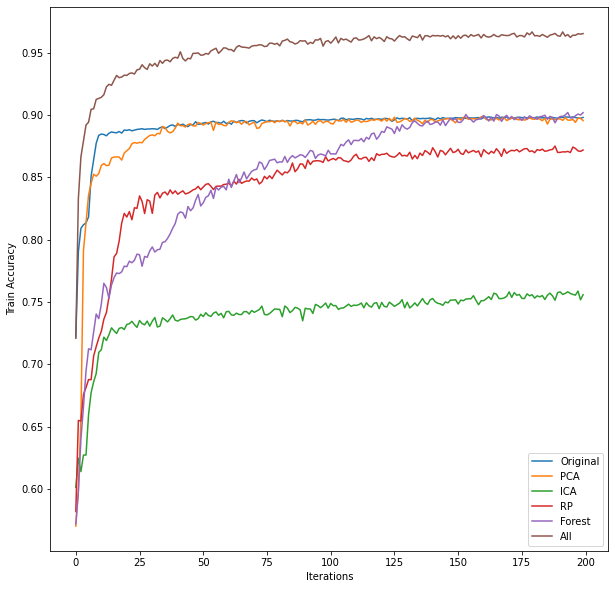

<Figure size 432x288 with 0 Axes>

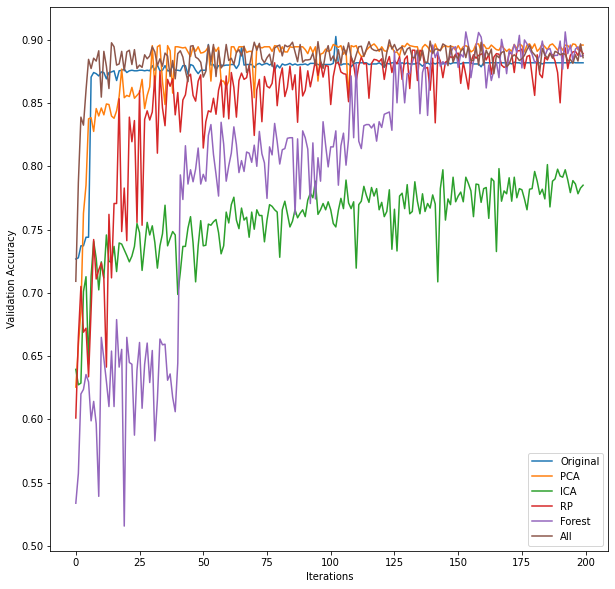

In [43]:
plt.figure(figsize=(10,10))
plt.plot(history_1.history['accuracy'], linestyle='-', label="Original")
plt.plot(history_2.history['accuracy'], linestyle='-', label="PCA")
plt.plot(history_3.history['accuracy'], linestyle='-', label="ICA")
plt.plot(history_4.history['accuracy'], linestyle='-', label="RP")
plt.plot(history_5.history['accuracy'], linestyle='-', label="Forest")
plt.plot(history_6.history['accuracy'], linestyle='-', label="All")
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Train Accuracy")
plt.show()
plt.savefig("Train-ANN.png")

plt.figure(figsize=(10,10))
plt.plot(history_1.history['val_accuracy'], linestyle='-', label="Original")
plt.plot(history_2.history['val_accuracy'], linestyle='-', label="PCA")
plt.plot(history_3.history['val_accuracy'], linestyle='-', label="ICA")
plt.plot(history_4.history['val_accuracy'], linestyle='-', label="RP")
plt.plot(history_5.history['val_accuracy'], linestyle='-', label="Forest")
plt.plot(history_6.history['val_accuracy'], linestyle='-', label="All")
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.savefig("Validation-ANN.png")
plt.show()